# A Tutorial for using Bandits for Travel Page Layout Optimization

- Robert F. Dickerson

Based on [An Efficient Bandit Algorithm for Realtime Multivariate Optimization](https://arxiv.org/pdf/1810.09558.pdf), Daniel Hill et. al. (Amazon.com) KDD'17

In [1]:
import pandas as pd
import random
import numpy as np
from scipy.stats import norm, bernoulli
import matplotlib.pyplot as plt
import itertools

np.random.seed(42)

## Page layout problem

Suppose a web page has a static layout containing multiple slots to put content. 

- Slot 1 can contain: 
    1. suit your style,
    2. map
    3. top rated
- Slot 2 can contain: 
    1. city info
    2. weather
    3. pricing
- Slot 3 can contain:
    1. reviews
    2. destination guide
    

### Example of widgets of Vrbo search page

View for example a [search page result for Barcelona](https://www.vrbo.com/vacation-rentals/europe/spain/catalunya/barcelona-province/barcelona)

It contains several widgets:

![widgets](pictures/vrbo-widgets.png)

Maybe there are some (pair-wise) interactions where placing the weather widget and the year pricing widget on the page at the same time boosts the chance of a reward more than the sum of its parts.

In this case, the number of potential layouts, $A$, are $3 \times 3 \times 2 = 18$

If we assume each slot can contain $N$ types of content, and there are $D$ slots then there are $N^D$ potential layouts. Quickly becomes a **combinatorial explosion!**

We can add context, $X$, such as time of year or user history so that perhaps certain widgets should be presented more often based on a user's viewing habit.

A feature vector can be formed $B_{A, X}$ combining layout and context.

Let's assume that a reward, $R$, could be that a booking was eventually made. $R \in \{-1, 1\}$

We can store the history $H_t$ of all the layouts users have seen as a tuple, $(A_t, X_t, R_t)$. 

## Generate random simulated data

Let's generate artificially some random combinations of content and assign the value for reward:

- If reviews is in slot 3 then a booking is $p=0.4$ likely.
- But if reviews is in slot 3 and top rated rentals are shown in slot 1 then a booking is $p=0.7$ likely.
- In all other cases, bookings are $p=0.2$ likely

This is highly simplistic example, but it does allow us to represent randomness with a Bernoulli trial. Every time we expose a user to a page layout we draw a random sample that is binary. It demonstrates interaction effects as well.




In [2]:
def simulate_behavior(s1, s2, s3):
    
    # draw a uniform random sample
    r = np.random.random()
    
    if s1 == 'top_rated' and s3 =='reviews':
        p = 0.7

    elif s3 == 'reviews':
        p = 0.4
        
    else: 
        p = 0.2
    
    return 1 if r > p else -1


In [27]:
choices_slot_1 = ["suit_style", "map", "top_rated"]
choices_slot_2 = ["city_info", "weather", "pricing"]
choices_slot_3 = ["reviews", "destination_guide"]

device_choices = ["web", "mobile"]

# number of random layouts to generate
N = 20

s1 = random.choices(choices_slot_1, k=N)
s2 = random.choices(choices_slot_2, k=N)
s3 = random.choices(choices_slot_3, k=N)

data = {'slot1': s1, 'slot2': s2, 'slot3': s3, 'reward': np.NaN}
H = pd.DataFrame(data=data, dtype='category')
H["slot1"] = H["slot1"].cat.set_categories(choices_slot_1)
H["slot2"] = H["slot2"].cat.set_categories(choices_slot_2)
H["slot3"] = H["slot3"].cat.set_categories(choices_slot_3)

#df["device_context"] = df["device_context"].cat.set_categories(['web', 'mobile'])

    
def to_features(df):
    """convert the slots to a feature vector"""
    df1 = df.copy()
    df2 = pd.get_dummies(df1, columns=["slot1", "slot2", "slot3"])
    df3 = df2.drop(columns=["reward"])
    return df3

def to_categories(df, columns):
    cat_df = pd.DataFrame()
    
    for col in columns:
        c = df.loc[:, df.columns.str.startswith(col)].idxmax(axis=1).str[len(col + '_'):]
        cat_df[col] = c
    return cat_df
    
def simulate(df):
    df['reward'] = df.apply(lambda x: simulate_behavior(x['slot1'], x['slot2'], x['slot3']), axis=1)
    return df
    
H_features = to_features(H)
H_slots = to_categories(H_features, ["slot1", "slot2", "slot3"])

features = to_features(H)

display(H)
display(H_features)
display(H_slots)

# s1 = pd.Series(["map", "pricing", "reviews"], index=["slot1", "slot2", "slot3"])
# H = H.append(s1, ignore_index=True)

H = simulate(H)
display(H)

H = pd.DataFrame(data=data, columns=["slot1", "slot2", "slot3"], dtype='category')
H["slot1"] = H["slot1"].cat.set_categories(choices_slot_1)
H["slot2"] = H["slot2"].cat.set_categories(choices_slot_2)
H["slot3"] = H["slot3"].cat.set_categories(choices_slot_3)


,slot1,slot2,slot3,reward
0,map,pricing,destination_guide,NaN
1,map,pricing,destination_guide,NaN
2,map,city_info,destination_guide,NaN
3,top_rated,weather,destination_guide,NaN
4,map,pricing,destination_guide,NaN
5,top_rated,city_info,destination_guide,NaN
6,suit_style,city_info,reviews,NaN
7,suit_style,weather,reviews,NaN
8,map,pricing,destination_guide,NaN
9,map,weather,destination_guide,NaN


,slot1_suit_style,slot1_map,slot1_top_rated,slot2_city_info,slot2_weather,slot2_pricing,slot3_reviews,slot3_destination_guide
0,0,1,0,0,0,1,0,1
1,0,1,0,0,0,1,0,1
2,0,1,0,1,0,0,0,1
3,0,0,1,0,1,0,0,1
4,0,1,0,0,0,1,0,1
5,0,0,1,1,0,0,0,1
6,1,0,0,1,0,0,1,0
7,1,0,0,0,1,0,1,0
8,0,1,0,0,0,1,0,1
9,0,1,0,0,1,0,0,1


,slot1,slot2,slot3
0,map,pricing,destination_guide
1,map,pricing,destination_guide
2,map,city_info,destination_guide
3,top_rated,weather,destination_guide
4,map,pricing,destination_guide
5,top_rated,city_info,destination_guide
6,suit_style,city_info,reviews
7,suit_style,weather,reviews
8,map,pricing,destination_guide
9,map,weather,destination_guide


,slot1,slot2,slot3,reward
0,map,pricing,destination_guide,1
1,map,pricing,destination_guide,1
2,map,city_info,destination_guide,-1
3,top_rated,weather,destination_guide,1
4,map,pricing,destination_guide,1
5,top_rated,city_info,destination_guide,-1
6,suit_style,city_info,reviews,1
7,suit_style,weather,reviews,-1
8,map,pricing,destination_guide,1
9,map,weather,destination_guide,1


## Online Learning

Refer to [Web-scale Bayesian Click-Through Rate Prediction for Sponsored Search Advertizing in Microsoft's Bing Search Engine]() Thore Graepel, et. al. (Microsoft.com), ICML 2010

\begin{align}
p(y | x, W) = \Phi(\frac{y \cdot w^T x}{\beta})
\end{align}


total variance:

\begin{align}
\Sigma^2 = \beta^2 + x^T*\sigma^2
\end{align}

Update the posterior values:
\begin{align}
\mu & := \mu + y x * \frac{\sigma^2}{\Sigma} \cdot v(\frac{y \cdot x^T\mu}{\Sigma}) \\
\sigma^2 & := \sigma^2 \cdot [1 - x \cdot \frac{\sigma^2}{\Sigma^2} \cdot w(\frac{y \cdot x^T\mu}{\Sigma}] \\
v(t) & = \frac{\mathcal{N}(t; 0, 1)}{\Phi(t; 0, 1)} \\
w(t) & = v(t) \cdot [v(t) + t]
\end{align}


In [7]:
def v(t):
    return norm.pdf(t)/norm.cdf(t)

def w(t):
    return v(t) * (v(t) + t)

def update(mu, sigma, feature, reward, beta=1):
    
    variance = beta**2 + feature*sigma
    Sigma = np.sqrt(variance)
        
    mu = mu + reward * feature * sigma**2/Sigma * v(reward*feature*mu/Sigma)
    sigma = sigma * (1 - feature * sigma**2/Sigma * w(reward * feature * mu/Sigma))
    return mu, sigma

In [8]:
def plot_weights(mu, sigma, t):
    
    d = mu.shape[0]
    fig, axs = plt.subplots(4, 2, constrained_layout=True)
    fig.suptitle("Weights beliefs $t={}$".format(t))

    for i in range(d):

        x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

        y = norm.pdf(x, loc=mu[i], scale=sigma[i])

        ri = i//2
        ci = i%2
        axs[ri, ci].plot(x, y, label=str(i))
        axs[ri, ci].fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        axs[ri, ci].set_title(r'$W_{}$'.format(i))


    plt.show()

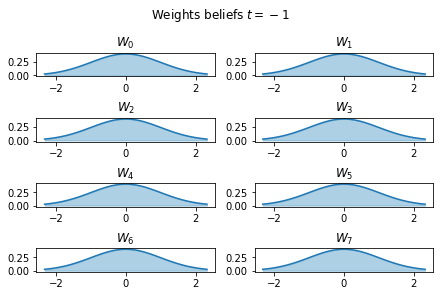

,slot1,slot2,slot3,reward
0,suit_style,weather,reviews,1
1,map,city_info,destination_guide,1
2,top_rated,pricing,destination_guide,1
3,top_rated,city_info,reviews,-1
4,top_rated,city_info,reviews,-1
5,map,city_info,reviews,-1
6,map,pricing,reviews,1
7,suit_style,pricing,destination_guide,1
8,suit_style,city_info,destination_guide,-1
9,suit_style,weather,reviews,-1


Running iteration 0


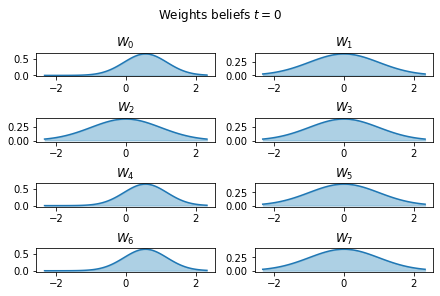

Running iteration 1


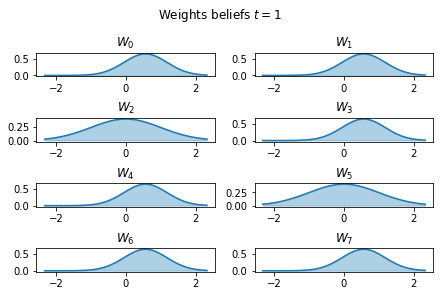

Running iteration 2


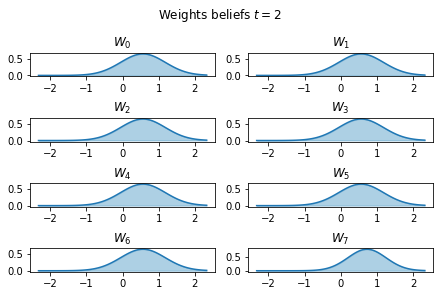

Running iteration 3


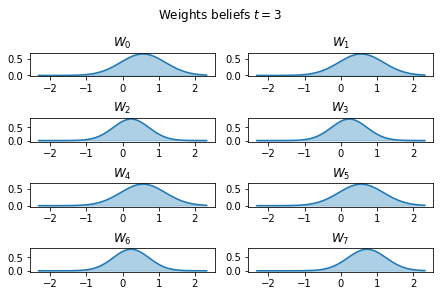

In [14]:
# time iterations
t = 4

# number of dimensions
d = 8

mu = np.zeros(d, np.float32)
sigma = np.ones(d, np.float32)

plot_weights(mu, sigma, -1)

H = simulate(H)
display(H)

features = to_features(H)

for i in range(t):
    print("Running iteration {}".format(i))
    row = H.iloc[i]
    feature = np.array(features.iloc[i].to_list())
    reward = row['reward']
        
    mu, sigma = update(mu, sigma, feature, reward)
    
    plot_weights(mu, sigma, i)

## Thompson Sampling

solve $\arg \max_A B^T_{A, X} W$

- for all $t = 1, \ldots, T$ do
    - receive context $X_t$
    - sample $W_T$ from the posterior $P(W|H_{t-1})$
    - select $A_t = \arg \max_A B^T_{A, X_t} W_t$
    - display layout $A_t$ and observe reward $R_t$
    - update $H_t = H_{t-1} \cup (A_t, R_t, X_t)$

In [18]:
w_tilde = np.random.normal(mu, sigma)

s1 = pd.Series(['top_rated', 'pricing', 'reviews'], index=["slot1", "slot2", "slot3"])
df = H.append(s1, ignore_index=True)

display(H)

b1 = np.array(to_features(H))
display(b1)

c1 = np.sum(b1*w_tilde)

display(norm.cdf(c1))

norm.cdf([c1])

,slot1,slot2,slot3,reward
0,suit_style,weather,reviews,1
1,map,city_info,destination_guide,1
2,top_rated,pricing,destination_guide,1
3,top_rated,city_info,reviews,-1
4,top_rated,city_info,reviews,-1
5,map,city_info,reviews,-1
6,map,pricing,reviews,1
7,suit_style,pricing,destination_guide,1
8,suit_style,city_info,destination_guide,-1
9,suit_style,weather,reviews,-1


array([[1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 1, 0]], dtype=uint8)

1.0

array([1.])

In [25]:
def search_space():
    b = itertools.product(choices_slot_1, choices_slot_2, choices_slot_3)
    c = [to_features(*x) for x in b]
    S = np.row_stack(c)
    print("Search space: \n {}".format(S))
    return S

def thompson_step(mu, sigma, H):

    # get context
    c = "US"
    
    # sample from the weights posterior
    w = np.random.normal(mu, sigma)
        
    # generate the search space
    S = search_space()
    
    # compute the posteriors for each
    s = np.sum(w * S, axis=1)
    s = norm.cdf(s)
    print("Probabilities of reward")
    print(s)

    # find the most likely layout
    best_index = np.argmin(s)
    best_layout = B[best_index]
    print(best_layout)
    
    
    #simulate and observe behavior
    
    
    mu, sigma = update(mu, sigma, best_layout, reward)
    
    plot_weights(mu, sigma, i)
    
    return mu, sigma, H
    
    

In [26]:
mu = np.zeros(d)
sigma = np.ones(d)

H = pd.DataFrame(columns=["slot1", "slot2", "slot3"])

for t in range(10):
    mu, sigma, H = thompson_step(mu, sigma, H)

TypeError: to_features() takes 1 positional argument but 3 were given